In [129]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

leveldb = pd.read_csv('../stbench_eval_out/pogrep/stats.csv')
leveldb

,time,state,reads,updates,inserts,total,mem,disk,files
0,1,recover,0,0,51886,51886,0,0,0
1,2,recover,0,0,50191,50191,0,0,0
2,3,recover,0,0,48181,48181,21200896,57222851,5
3,4,recover,0,0,54000,54000,21200896,57222851,5
4,5,recover,0,0,53086,53086,31535104,114528412,5
...,...,...,...,...,...,...,...,...,...
83,84,iterate,1731,0,0,1731,308580352,572595038,8
84,85,iterate,1891,0,0,1891,306184192,572595136,8
85,86,iterate,1789,0,0,1789,306184192,572595136,8
86,87,iterate,1868,0,0,1868,304971776,572595234,8


In [130]:


states = {}

prevState = ""
for index, row in leveldb.iterrows():
    state = row['state']
    time = row['time']
    if state not in states:
        states[state] = []
    
    stateList = states[state]

    
    # state did not change, just change the end-time of the last item
    if prevState == state:
        stateList[-1][1] = time
    else:
        # state changed, create a new block
        stateList.append([time, time])
        
    prevState = state
    
    

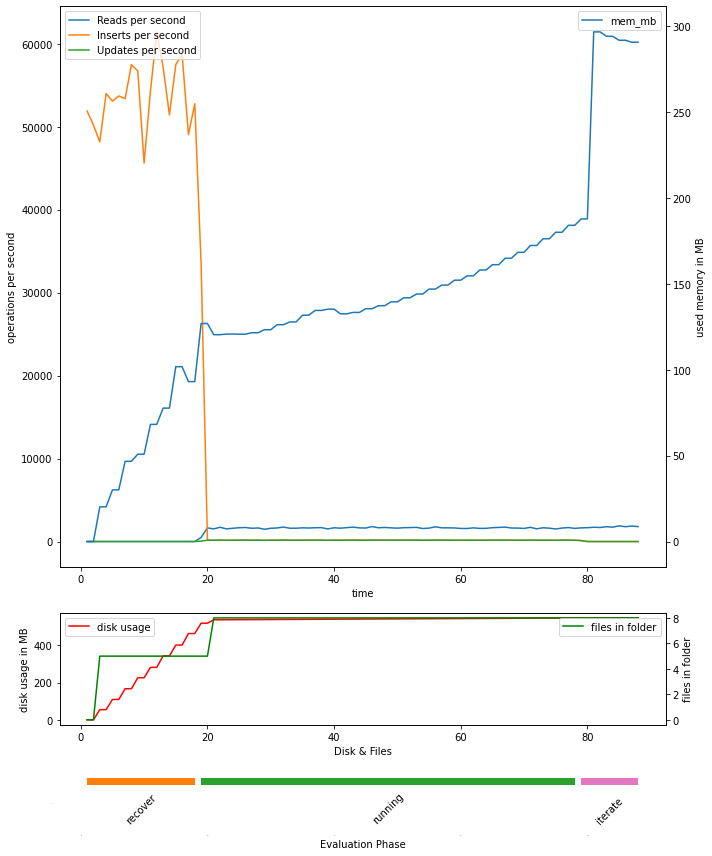

In [131]:
fig, (ax, diskAx, stateAx) = plt.subplots(3, figsize=(10,12),  gridspec_kw={'height_ratios': [20,4,2]})
memAx = ax.twinx()

leveldb['mem_mb'] = leveldb['mem'] / (1024*1024)

colors = {'open':'blue',
          'recover':'orange',
          'reopen':'olive',
          'running':'green',
          'commit':'purple',
          'close':'gray',
          'prepare-run':'orange',
          'iterate':'pink',
         }
         

stateList = [] 
colorList = [] 
stateLabelList = [] 

for state, stateSlots in states.items():
    for s in stateSlots:
        stateList.append([s[0], s[1]-s[0]])
        colorList.append("tab:"+colors.get(state, 'red'))
        stateLabelList.append(state)
       
    

ax.set_xlabel('time')
ax.set_ylabel('operations per second')
memAx.set_ylabel('used memory in MB')
opsMax = leveldb['reads'].quantile(q=0.9)
leveldb.plot(x='time', y=['reads', 'inserts', 'updates'], ax=ax, label=["Reads per second","Inserts per second", "Updates per second"])
leveldb.plot(x='time', y='mem_mb', ax=memAx)
ax.legend(loc='upper left')
# ax.set_ylim(0,opsMax)
memAx.legend(loc='upper right')

stateAx.set_ylim(0,16)
stateAx.set_xlabel('Evaluation Phase')
stateAx.set_yticks([7])
stateAx.tick_params('both', width=0,labelsize=0)
stateAx.broken_barh(stateList, [12,2], facecolors=colorList)

for pos in ['left', 'right', 'top', 'bottom']:
    stateAx.spines[pos].set_visible(False)

fig.tight_layout()

for i, state  in enumerate(stateList):
    stateAx.text(x=state[0] + state[1]/2.0, ha="center", y=1, rotation=45, s=stateLabelList[i])

fileAx = diskAx.twinx()


leveldb['disk_mb'] = leveldb['disk'] / (1024*1024)

leveldb.plot(x='time', y='files', ax=fileAx, color="green", label="files in folder")
leveldb.plot(x='time', y='disk_mb', ax=diskAx, color="red", label="disk usage")
fileAx.legend(loc='upper right')
fileAx.set_ylabel('files in folder')
diskAx.set_ylabel('disk usage in MB')
diskAx.legend(loc='upper left')
diskAx.set_xlabel("Disk & Files")

fig.savefig('leveldb.png')